cvt_census.ipynb

Discussion: Compute Florida congressional districts using census data.

Licensing: This code is distributed under the GNU LGPL license.
    
Modified: 14 November 2016

Author: John Burkardt, Lukas Bystricky

In [14]:
# Import necessary libraries and set plot option
%matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.spatial as spatial
print(3+1)

Using matplotlib backend: Qt4Agg
4


# 27 Florida Congressional Districts from Census Data #

Legally, Florida must be divided up into 27 congressional districts of roughly equal population.  This process can be manipulated to favor a particular party or candidate.  It is interesting to investigate the shape of districts that might be computed by an approach inspired by CVT's. 

We will look at:
* how to read a file containing usable census data;
* how to set up the PDF and CDF data from the census data;
* how to use the CDF data to randomly select a single person at random in Florida;
* how to sample N persons from Florida, with their latitudes and longitudes;
* how to initialize each congressional district's "generator" point;
* how to compute the nearest generator point to each selected person;
* how to carry out a CVT iteration that, on each step, selects N random persons, assigns them to nearest generator, and replaces generator by centroid.

# Get Florida Polygon Vertices #

We will want to display some data on a map of Florida, so once again we need to
read the shape of the Florida polygon.  We will save the data in FLA_LON and
FLA_LAT.

    0  -81.5000   30.7200
    1  -81.4800   30.6800
    2  -81.4500   30.7000
    3  -81.4300   30.6800
    4  -81.4500   30.5700
    5  -81.4300   30.5200
    6  -81.4700   30.5500
    7  -81.4800   30.6200
    8  -81.5000   30.6200
    9  -81.5000   30.5500
...
  560  -81.7800   30.7700
  561  -81.7300   30.7700
  562  -81.7200   30.7500
  563  -81.6800   30.7300
  564  -81.6500   30.7300
  565  -81.6300   30.7300
  566  -81.6200   30.7200
  567  -81.5500   30.7000
  568  -81.5200   30.7200
  569  -81.5000   30.7200


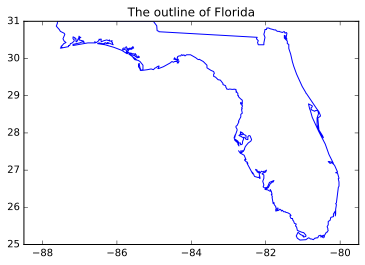

In [15]:
# Code to read and display longitude and latitude for Florida polygon vertices

def florida_shape_read ( ):

    fla_lon = np.zeros(571)
    fla_lat = np.zeros(571)
    i = 0
    
    input = open("C:\\Users\\Jacob\\Pictures\\florida_shape.txt", 'r')
    
    for line in input:
        fla_lon[i] = float(line.split()[0])
        fla_lat[i] = float(line.split()[1])
        i += 1
    
    fla_lon[570] = fla_lon[0]
    fla_lat[570] = fla_lat[0]
    
    return fla_lon, fla_lat
#
#  Test the function.
#
fla_lon, fla_lat = florida_shape_read ( )
for i in range ( 0, 10 ):
  print ( '  %3d  %8.4f  %8.4f' % ( i, fla_lon[i], fla_lat[i] ) ) 
print ( '...')
for i in range ( 560, 570 ):
  print ( '  %3d  %8.4f  %8.4f' % ( i, fla_lon[i], fla_lat[i] ) ) 

plt.plot ( fla_lon, fla_lat, 'b-' )
plt.axis ( 'Equal')
plt.title ( 'The outline of Florida')

# A Census Data File#

The file "florida_census.txt" is available from the web page 
http://people.sc.fsu.edu/~jburkardt/classes/urop_2016/florida_census.txt

For 4,245 locations in Florida, the US Census Bureau recorded an identifying
ID number (which we will ignore), the population, the longitude and latitude.

Note that this file is not the original data from the Census Bureau website.
Many piece of information were removed to reduce the file size and simplify
the processing step.  Also, a number of legitimate locations (especially in
Key West!) fall outside the polygon that we use to represent the shape of Florida.
In order to avoid some confusing results, we set the populations of those
sites to zero!

Now we need to read this file and make its data available to our Python codes.

In [16]:
# Code to read the census data file.

def florida_census_read ( ):
    
    cen_pop, cen_lon, cen_lat = np.zeros(4245), np.zeros(4245), np.zeros(4245)
    i = 0
    
    input = open("C:\\Users\\Jacob\\Pictures\\florida_census.txt", 'r')
    
    for line in input:
        cen_pop[i] = float(line.split()[1])
        cen_lon[i] = float(line.split()[2])
        cen_lat[i] = float(line.split()[3])
        i += 1
    
    
    return cen_pop, cen_lon, cen_lat
#
#  Test the function.
#
cen_pop, cen_lon, cen_lat = florida_census_read ( )
m = len ( cen_pop )

print ( '' )
print ( '    I     Pop       Lon       Lat' )
print ( '' )
for i in range ( 0, 10 ):
  print ( '  %3d  %6d  %8.4f  %8.4f' % ( i, cen_pop[i], cen_lon[i], cen_lat[i] ) ) 
print ( '...')
for i in range ( m - 10, m ):
  print ( '  %3d  %6d  %8.4f  %8.4f' % ( i, cen_pop[i], cen_lon[i], cen_lat[i] ) ) 


    I     Pop       Lon       Lat

    0    7431  -82.3334   29.6511
    1    3308  -82.3314   29.6680
    2    2770  -82.3301   29.6842
    3    5665  -82.3081   29.6795
    4    4976  -82.3169   29.6568
    5    4350  -82.2885   29.6558
    6    6075  -82.2902   29.6317
    7    2180  -82.3322   29.6390
    8    3630  -82.3335   29.6274
    9    1364  -82.3493   29.6305
...
  4235    2506  -86.0550   30.3097
  4236    7367  -86.3621   30.3869
  4237       0  -86.1947   30.3021
  4238    1651  -85.5683   30.7151
  4239    3335  -85.5911   30.7873
  4240    3228  -85.4889   30.7741
  4241    3624  -85.7855   30.6721
  4242    2282  -85.5749   30.5019
  4243    6615  -85.7626   30.5286
  4244    4161  -85.5266   30.6417


# Setting up PDF and CDF from Census Data #

We have seen earlier that we could sample points from a polygon by computing
areas of triangles and creating PDF and CDF files that represented the 
probability and cumulative probability functions.  The population data can
be used in a similar way.

Since we have 4,245 locations, the probability of picking a person at a particular
location is simply the population of that location, divided by the total population.
So we need to create an array called PDF, so that

    pdf[i] = cen_pop[i] / sum ( cen_pop[0:4245] )  (Use REAL arithmetic!)
    
The CDF array will record the probability of picking a person from location I,
or any earlier index.  So

    cdf[0] = pdf[0]             for i = 0
    cdf[i] = pdf[i] + cdf[i-1]  for i > 0

If things are done correctly, then cdf[4244] should be 1.0, or very close to it.

In [17]:
# Code to set up PDF and CDF from Census Data #

m = len ( cen_pop )
cen_pop_sum = sum(cen_pop)
pdf = cen_pop / cen_pop_sum
cdf = np.zeros(m)

cdf[0] = pdf[0]
for i in range ( 1, m ):
    cdf[i] = pdf[i] + cdf[i-1]

print ( '' )
print ( '    I     Pop       Lon       Lat       PDF       CDF' )
print ( '' )
for i in range ( 0, 10 ):
  print ( '  %3d  %6d  %8.4f  %8.4f  %8.4g  %8.4f' % ( i, cen_pop[i], cen_lon[i], cen_lat[i], pdf[i], cdf[i] ) ) 
print ( '...')
for i in range ( m - 10, m ):
  print ( '  %3d  %6d  %8.4f  %8.4f  %8.4g  %8.4f' % ( i, cen_pop[i], cen_lon[i], cen_lat[i], pdf[i], cdf[i] ) ) 


    I     Pop       Lon       Lat       PDF       CDF

    0    7431  -82.3334   29.6511  0.0004105    0.0004
    1    3308  -82.3314   29.6680  0.0001827    0.0006
    2    2770  -82.3301   29.6842  0.000153    0.0007
    3    5665  -82.3081   29.6795  0.0003129    0.0011
    4    4976  -82.3169   29.6568  0.0002749    0.0013
    5    4350  -82.2885   29.6558  0.0002403    0.0016
    6    6075  -82.2902   29.6317  0.0003356    0.0019
    7    2180  -82.3322   29.6390  0.0001204    0.0020
    8    3630  -82.3335   29.6274  0.0002005    0.0022
    9    1364  -82.3493   29.6305  7.534e-05    0.0023
...
  4235    2506  -86.0550   30.3097  0.0001384    0.9982
  4236    7367  -86.3621   30.3869  0.0004069    0.9986
  4237       0  -86.1947   30.3021         0    0.9986
  4238    1651  -85.5683   30.7151  9.119e-05    0.9987
  4239    3335  -85.5911   30.7873  0.0001842    0.9989
  4240    3228  -85.4889   30.7741  0.0001783    0.9991
  4241    3624  -85.7855   30.6721  0.0002002    0.9993


# Selecting Random People #

The CDF function makes it easy to select N random people from Florida
by location.  Any random number R between 0 and 1 can be bracketed between
CDF[I-1] and CDF[I], meaning we should pick a person from location I.
Since we will assume that all the people at location I are at exactly the
same spot, CEN_LON[I], CEN_LAT[I], we know everything we want to about the person now.

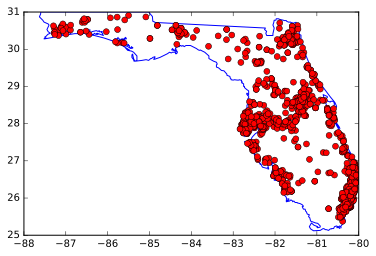

In [18]:
# Code for selecting N random people

def florida_sample ( n ):
    indx = np.zeros ( n, dtype = np.int32 )
    for i in range(n):
        num = np.random.rand() 
        for j in range(m):
            if num < cdf[j]:    
                indx[i] = j
                break
        
    return indx
#
#  Test the code.
#

n = 1000
indx = florida_sample ( n )

plt.plot ( fla_lon, fla_lat, 'b-' )
plt.plot ( cen_lon[indx], cen_lat[indx], 'ro' )

# Initialize generators for Congressional Districts #

A CVT iteration needs starting values for its generators.
We have a list of 27 cities, each of which is inside a
particular Congressional district.  Use these as initial
values for G.

    Name                     Longitude       Latitude
    ------------------      ----------       ---------
    Chumuckla               -87.237222       30.776389
    Tallahassee             -84.253333       30.455000
    Gainesville             -82.324722       29.651944
    Callahan                -81.830833       30.560833
    Jacksonville            -81.661389       30.336944
    Jacksonville Beach      -81.396111       30.284167
    Winter Park             -81.346667       28.596111
    Rockledge               -80.732778       28.325000
    Kissimmee               -81.412778       28.303889
    Orlando                 -81.298889       28.415833
    Spring Hill             -82.547778       28.478889
    Palm Harbor             -82.753889       28.083889
    Indian Shores           -82.843333       27.850556
    Tampa                   -82.476389       27.968056
    Lakeland                -81.958889       28.041111
    Longboat Key            -82.644722       27.396944
    Okeechobee              -80.833333       27.233333
    Jupiter                 -80.105000       26.926111
    Bonita Springs          -81.790833       26.349722
    Miramar                 -80.282500       25.978889
    Boca Raton              -80.100000       26.368611
    West Palm Beach         -80.064167       26.709722
    Weston                  -80.388056       26.107500
    Miami Gardens           -80.269722       25.941944
    Hialeah                 -80.293889       25.860556
    Kendall                 -80.356667       25.666667
    Miami                   -80.208889       25.775278

1.0

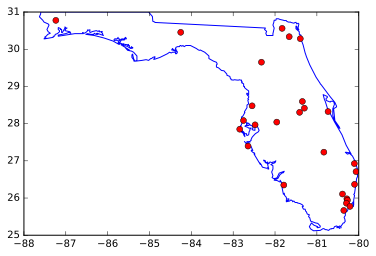

In [19]:
g27 = np.array ( [ \
  [ -87.237222,       30.776389], \
  [ -84.253333,       30.455000], \
  [ -82.324722,       29.651944], \
  [ -81.830833,       30.560833], \
  [ -81.661389,       30.336944], \
  [ -81.396111,       30.284167], \
  [ -81.346667,       28.596111], \
  [ -80.732778,       28.325000], \
  [ -81.412778,       28.303889], \
  [ -81.298889,       28.415833], \
  [ -82.547778,       28.478889], \
  [ -82.753889,       28.083889], \
  [ -82.843333,       27.850556], \
  [ -82.476389,       27.968056], \
  [ -81.958889,       28.041111], \
  [ -82.644722,       27.396944], \
  [ -80.833333,       27.233333], \
  [ -80.105000,       26.926111], \
  [ -81.790833,       26.349722], \
  [ -80.282500,       25.978889], \
  [ -80.100000,       26.368611], \
  [ -80.064167,       26.709722], \
  [ -80.388056,       26.107500], \
  [ -80.269722,       25.941944], \
  [ -80.293889,       25.860556], \
  [ -80.356667,       25.666667], \
  [ -80.208889,       25.775278] ] )
#
#  Test the code.
#
plt.plot ( fla_lon, fla_lat, 'b-' )
plt.plot ( g27[:,0], g27[:,1], 'ro' )
from numpy.linalg import norm
norm( np.array([1,1]) - np.array([2,1]) )

# CVT step for Florida #

Now we can write the CVT step for Florida.

Given M current generators G, and using N sample points, we want to
estimate the M centroids C of the corresponding Voronoi regions.


In [61]:
def cvt_step_florida ( g, m ):
    n = len(g)
    m_pts = better_florida_sample(m)
    m_gen = np.zeros(m)
    g_pop = np.zeros(n)
    c     = np.zeros( [n,2] )
    
    for i in range(m):
        dist = 20
        #samp = np.array([cen_lon[m_ind[i]], cen_lat[m_ind[i]]])
        
        for j in range(n):
            temp_dist = norm(g[j] - m_pts[i])
            if temp_dist < dist:
                dist = temp_dist
                m_gen[i] = j
        g_pop[int(m_gen[i])] += 1
        
        c[int(m_gen[i])] += m_pts[i]
        
    for i in range(n):
        if g_pop[i] != 0:
            c[i] /= g_pop[i]
        else:
            c[i]  = g[i]
        
    return c
print(m)

4245


In [68]:
#  cvt_step_florida()
#
def cvt_step_florida ( g, m ):
    n = len(g)
    m_pts = better_florida_sample(m)
    m_gen = np.zeros(m)
    g_pop = np.zeros(n)
    c     = np.zeros( [n,2] )
    
    for i in range(m):              #loops for each point to see which generator it's closest to
        dist = 20
        for j in range(n):          #loops for each generator to see which distance is shortest
            temp_dist =  norm(m_pts[i] - g[j])
            if temp_dist < dist:
                dist = temp_dist
                m_gen[i] = j
        g_pop[int(m_gen[i])] += 1   #increases population array at index of closest generator
        
        c[int(m_gen[i])] += m_pts[i]    #adds the values per subregion
        
    for i in range(n):
        if g_pop[i] != 0:
            c[i] /= g_pop[i]
        else:
            c[i]  = g[i]
        
    return c, m_pts, m_gen
#
#  Test the function using 7 Florida cities to start with.
#
import numpy as np


n = 1000
c, m_pts, m_gen = cvt_step_florida ( g27, n )
print ( c   )
#dot_plot27(m_pts, m_gen, 27)

[[-86.94525455  30.48951818]
 [-84.61160556  30.38515278]
 [-82.28192667  29.57036222]
 [-81.70033333  30.57113333]
 [-81.68409796  30.23444082]
 [-81.37605758  29.95206061]
 [-81.40885     28.77127   ]
 [-80.68562812  28.17007188]
 [-81.46524     28.295196  ]
 [-81.28738333  28.45089444]
 [-82.44351562  28.52505625]
 [-82.7298963   28.08147037]
 [-82.69796316  27.78004211]
 [-82.42237838  28.01409189]
 [-81.87363611  27.95398333]
 [-82.42586667  27.29312917]
 [-80.77207     27.33745   ]
 [-80.22526667  27.08487778]
 [-81.80387083  26.47137708]
 [-80.235175    26.0467125 ]
 [-80.15375397  26.30186984]
 [-80.12890435  26.66406957]
 [-80.30341667  26.14735   ]
 [-80.202268    25.937208  ]
 [-80.30765714  25.84894286]
 [-80.39312241  25.64617759]
 [-80.22237037  25.78035926]]


# CVT Iteration for Florida #

Once we have a CVT step function, the CVT iteration is easy.  Try taking 10 steps,
and plot the locations of G before the iteration, and then at the end.

You may also be able to plot the Voronoi diagram on top of the plot of the cities.

In [70]:
# Code for CVT Iteration for Florida
#
def cvt_florida ( g, n, step_num ):

  vor = spatial.Voronoi ( g )
  spatial.voronoi_plot_2d ( vor )
  plt.plot ( g[:,0], g[:,1], 'r.' )
  plt.plot ( fla_lon, fla_lat, 'b-' )
  plt.axis ( 'Equal' )
  plt.axis ( 'Off')
  plt.axis ( [-88.5, -79.5, 25,31])
  e = str(energy_square(g, n))
  plt.title ( 'Energy = ' + e)
  plt.xlabel( 'Before CVT iteration')
  plt.savefig ( "FloridaCVTBefore.png", dpi = 500 )

  c, m_pts, m_gen = cvt_step_florida ( g, n )
  plt.cla()
  plt.axis ( 'Equal' )
  plt.axis ( 'Off')
  plt.axis ( [-88.5, -79.5, 25,31])
  dot_plot27 ( m_pts, m_gen, 0)
    
  for step in range ( 0, step_num - 1):
    c, m_pts, m_gen = cvt_step_florida ( g, n )
    g = c.copy ( )
  return g
#
#  Test the code.
#
g = g27.copy ( )
n = 10000
step_num = 249
g = cvt_florida ( g, n, step_num )

vor = spatial.Voronoi ( g )
spatial.voronoi_plot_2d ( vor )
plt.plot ( g[:,0], g[:,1], 'r.' )
plt.plot ( fla_lon, fla_lat, 'b-' )
plt.axis ( 'Equal' )
plt.axis ( 'Off')
plt.axis ( [-88.5, -79.5, 25,31])
e = str(energy_square(g, m))
plt.title ( 'Energy = ' + e)
plt.xlabel ( 'After CVT iteration')
plt.savefig ( "FloridaCVTAfter.png", dpi = 500 )

c, m_pts, m_gen = cvt_step_florida ( g, n )
plt.cla()
plt.axis ( 'Equal' )
plt.axis ( 'Off')
plt.axis ( [-88.5, -79.5, 25,31])
dot_plot27 ( m_pts, m_gen, 500)

In [59]:
def dot_plot27(m_pts, m_gen, n):
    colors = ['#40303d', '#f20000', '#330d0d', '#8c3800', \
              '#ffb380', '#d99100', '#4c4113', '#ffee00', \
              '#bfb960', '#90ff80', '#1a662e', '#36d9b8', \
              '#3dcef2', '#0d2b33', '#7c9da6', '#0080bf', \
              '#0047b3', '#001a40', '#3a00d9', '#aa79f2', \
              '#ff00ee', '#8c2385', '#ff0000', '#330022', \
              '#ff0088', '#d9a3bf', '#cc3347' ]
    for i in range(len(m_pts)):
        plt.plot(m_pts[i][0], m_pts[i][1], '.', color = colors[int(m_gen[i])])
    plt.savefig("CVT" + str(n) + "Dots.png", dpi = 500)

In [32]:
def better_florida_sample ( n ):
    indx = np.zeros ( n, dtype = np.int32 )
    m_pts = np.zeros ( [n,2] )
    for i in range(n):
        num = np.random.rand() 
        for j in range(m):
            if num < cdf[j]:    
                indx[i] = j
                break
    
    for i in range(len(indx)):
        m_pts[i] = np.array ([cen_lon[indx[i]],cen_lat[indx[i]]])
        
    return m_pts

print(better_florida_sample(4))


[[-80.2549  25.8864]
 [-82.7132  28.0285]
 [-80.4287  27.68  ]
 [-80.3939  27.3298]]


In [66]:
def energy_square ( g, m ):
    e = 0
    n = len(g)
    m_pts = better_florida_sample(m)     #sample points
    m_gen = np.zeros(m)             #closest generater for point
    c = np.zeros( [n,2] )
    for i in range(m):              #loops for each point to see which generator it's closest to
        dist = 20
        for j in range(n):          #loops for each generator to see which distance is shortest
            temp_dist =  norm(m_pts[i] - g[j])
            if temp_dist < dist:
                dist = temp_dist
                m_gen[i] = j
    for i in range(m):
       
        e += norm(m_pts[i] - g[int(m_gen[i])])**2
    
    e /= m/10
    return e
print(energy_square(g27, 10000))
test = cvt_step_florida ( g27, n )
print(energy_square(test, 10000))

1.0523223362
0.762843088847


--
[[44, 18, 17, 0, 1, 43], [42, 13, 4, 1, 0, 41], [31, 15, 12, 13, 4, 29], [1, 4, 29, 30, 46, 45], [31, 29, 30], [30, 31, 15, 14, 16, 47, 48], [25, 12, 15, 14, 19, 20, 24], [21, 11, 10, 16, 14, 19], [26, 11, 21, 20, 24], [21, 19, 20], [42, 13, 12, 25, 36, 40], [42, 40, 39, 41], [41, 0, 17, 37, 39], [40, 36, 38, 37, 39], [38, 28, 27, 26, 24, 25, 36], [38, 28, 18, 17, 37], [27, 9, 8, 7, 10, 11, 26], [16, 10, 7, 49, 50], [52, 51, 2, 9, 27, 28, 18], [35, 22, 23, 33], [54, 53, 3, 22, 35, 34], [7, 8, 3, 55, 56], [23, 6, 2, 9, 8, 3, 22], [35, 33, 32, 34], [33, 23, 6, 5, 32], [58, 57, 5, 6, 2], [59, 60, 34, 32, 5]]
--
[[ -86.0486416    27.79915507]
 [ -83.82548085   48.43976472]
 [ -81.15807752   25.83113751]
 [ -80.56274191   26.58965866]
 [ -83.04756371   30.63336896]
 [ -80.3106303    25.75886882]
 [ -80.64636329   25.86757352]
 [ -80.62240958   26.71642774]
 [ -80.66958866   26.64712333]
 [ -81.04265688   26.49957152]
 [ -80.19690443   27.72517529]
 [ -81.0569432    27.80439469]
 [ -81.99

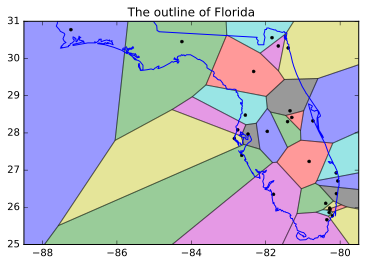

In [77]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi

def voronoi_finite_polygons_2d(vor, radius=None):
    """
    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.

    Parameters
    ----------
    vor : Voronoi
        Input diagram
    radius : float, optional
        Distance to 'points at infinity'.

    Returns
    -------
    regions : list of tuples
        Indices of vertices in each revised Voronoi regions.
    vertices : list of tuples
        Coordinates for revised Voronoi vertices. Same as coordinates
        of input vertices, with 'points at infinity' appended to the
        end.

    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

# make up data points
np.random.seed(5671)
points = g27

# compute Voronoi tesselation
vor = Voronoi(points)

# plot
regions, vertices = voronoi_finite_polygons_2d(vor)
print ("--")
print (regions)
print ("--")
print (vertices)

# colorize
for region in regions:
    polygon = vertices[region]
    plt.fill(*zip(*polygon), alpha=0.4)

plt.plot(points[:,0], points[:,1], 'k.')
plt.xlim(vor.min_bound[0] - 0.1, vor.max_bound[0] + 0.1)
plt.ylim(vor.min_bound[1] - 0.1, vor.max_bound[1] + 0.1)
plt.plot ( fla_lon, fla_lat, 'b-' )
plt.axis ( 'Equal')
plt.axis ( [-88.5, -79.5, 25,31])
plt.title ( 'The outline of Florida')
plt.show()